# SITCOM-1399: Adding Earthquake events to the TN81, on vibration on M1M3

2024-06-10 Laura Toribio San Cipriano

**Descripción**

Sub-ticket related to the [SITCOM-918: Write technote on hardpoint oscillations during tma slews](https://rubinobs.atlassian.net/browse/SITCOM-918), to study earthquake events seen by M1M3. 
We can read the TN81 [here](https://sitcomtn-081.lsst.io/v/SITCOM-918/index.html).

See more about the ticket in: [https://rubinobs.atlassian.net/browse/SITCOM-1399](https://rubinobs.atlassian.net/browse/SITCOM-1399)



**More information**

The **VMS (Vibration Monitoring System)** is a set of accelerometers mounted on the M1M3, M2, and Camera Rotator that measure high frequency accelerations (not including gravity). The data rate is 200 hz, and so can be used to identify vibrations up to 100 hz. More information can be found [confluence](https://confluence.lsstcorp.org/x/jQhUCQ). There are multiple sensors on each of the three components. In particular, for M1M3 has 3 sensors.

The VMS data for the mag~6 earthquake of September are shown in slides no. 56 and 57 available [here](https://docs.google.com/presentation/d/1HmmzIUt0XszK0XMS1YZtQiYCvdwajhrZ8p3ZdAVSp14/edit#slide=id.g2633a5ccbdd_1_394).

In this notebook we will study whether this type of event is safe for the mirror.

The dates of large earthquakes are:
- 2023-09-06 23:48:15 UTC
- 2023-10-31 12:33:43 UTC

## Function the read VMS data

In [15]:
import sys, time, os, asyncio
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy import signal
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, clipDataToEvent, calcNextDay
import matplotlib.dates as mdates
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Functions to get data
# Modified functions of ticket SITCOM-761

key_m1m3_dict={'1 X': 'm1m3_x_1', 
            '1 Y': 'm1m3_y_1', 
            '1 Z': 'm1m3_z_1', 
            '2 X': 'm1m3_x_2', 
            '2 Y': 'm1m3_z_2', # note these two have been 
            '2 Z': 'm1m3_y_2', # switched pending SUMMIT-7911
            '3 X': 'm1m3_x_3', 
            '3 Y': 'm1m3_y_3', 
            '3 Z': 'm1m3_z_3'
            }

def vms_data_to_pandas(filename, vms_type, begin_time=None, end_time=None):
    """
    Converts VMS data in the given HDF5 file to a Pandas DataFrame.

    Args:
    filename: Path to the HDF5 file containing the VMS data.
    vms_type: The type of VMS data in the file. Must be "m1m3", "m2", or
      "rotator".
    begin_time: The start time of the data to include in the DataFrame. If None,
      all data will be included.
    end_time: The end time of the data to include in the DataFrame. If None, all
      data will be included.

    Returns:
    A Pandas DataFrame containing the VMS data.
    """
    if vms_type == "m1m3":
        key_dict=key_m1m3_dict
    #elif vms_type=="m2":
    #    key_dict=key_m2_dict
    #elif vms_type=="rotator":
    #    raise NotImplementedError
    else:
        raise ValueError('vms_type must be m1m3,m2, or rotator')

    f = h5py.File(filename, 'r')
    times = f['timestamp'][::1]
    dkeys = 'XYZ'
   
    data_dict = {}
    if (begin_time is not None) & (end_time is not None): 
        sel = (times > begin_time) & (times < end_time)
    else: 
        sel = np.ones(times.size).astype(bool)
    data_dict['times'] = times[sel]  
    for key in key_dict.keys():
        data_dict[key_dict[key]] = f[key][::1][sel]
    data_frame = pd.DataFrame(data_dict)
    for j in np.arange(int(len(key_dict)/3)) +1:
        data_frame[f"total_{j}"] = np.linalg.norm(
            data_frame[[f"{vms_type}_{i}_{j}" for i in ["x","y","z"]]].values, axis=1
        )
    
    
    return data_frame

def get_efd_data(begin, end, client):

    """Extract all the MTMount data from the EFD and add to dict.

    Args:
        begin (str): The start time of the query.
        end (str): The end time of the query.
        client (object): influx client

    Returns:
        dict: A dictionary containing the MTMount data.
    """

    query_dict = {}

    query_dict["el"] = getEfdData(
        client,
        "lsst.sal.MTMount.elevation",
        columns=["private_sndStamp", "private_efdStamp", "actualPosition", "actualVelocity", "actualTorque"],
        begin=begin,
        end=end,
        prePadding=0,
        postPadding=0,
        warn=False,
    )
    query_dict["az"] = getEfdData(
        client,
        "lsst.sal.MTMount.azimuth",
        columns=["private_sndStamp", "private_efdStamp", "actualPosition", "actualVelocity", "actualTorque"],
        begin=begin,
        end=end,
        prePadding=0,
        postPadding=0,
        warn=False,
    )
    return query_dict


In [17]:
def get_freq_psd(vals, timestep):

    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.
    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.
    N = len(signal)

    # Calculate the power spectral density.
    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.
    frequencies = np.fft.rfftfreq(N, timestep)

    return (frequencies, psd)

def get_peak_points(freq, psd, height=0.01):
    """
    Get the peak points of the power spectral density (PSD).

    Args:
        freq (numpy.ndarray): The frequency vector.
        psd (numpy.ndarray): The power spectral density.
        height (float): The minimum peak height.

    Returns:
        numpy.ndarray: The peak points.
    """

    # Find the peak indices and heights.
    peak_ind, peak_dict = find_peaks(psd, height=height)
    peaks = freq[peak_ind]

    # If there are no peaks, return None.
    if len(peaks) < 1:
        return None

    # Find the sub-peaks within each group of peaks that are close in frequency.
    points = []
    for i, peak in enumerate(peaks):
        sel = (abs(peaks - peak) < 1)
        sub_peaks = peaks[sel]
        sub_heights = peak_dict['peak_heights'][sel]
        points.append(sub_peaks[np.argmax(sub_heights)])

    # Return the unique peak points.
    return np.unique(np.array(points))

## Analysis for the evening's event:  2023-09-06

### Loading VMS data

We analysed de data of the earthquake event of 6 September 2023.

In [18]:
#vms_m1m3_filename="/scratch/users/b/boutigny/vmsdata/09/M1M3-2023-09-06T00:00.hdf"
vms_m1m3_filename="/scratch/users/b/boutigny/vmsdata/2023/09/M1M3-2023-09-06T00:00.hdf"
begin_time=Time('2023-09-06 23:47:00', format="iso", scale="utc")
end_time=Time('2023-09-06 23:54:00', format="iso", scale="utc")

In [19]:
client=makeEfdClient()
efd_dict=get_efd_data(begin_time, end_time, client)
vms_m1m3_data=vms_data_to_pandas(vms_m1m3_filename, vms_type="m1m3",begin_time=begin_time.unix, end_time=end_time.unix)

### Plotting the VMS data - 6 September 2023
 1. Plot of acceleration telemetry
 2. A Power Spectral Distribution (psd)

#### Acceleration

1.1. Total acceleration telemetry for each of the 3 m1m3 vms channels

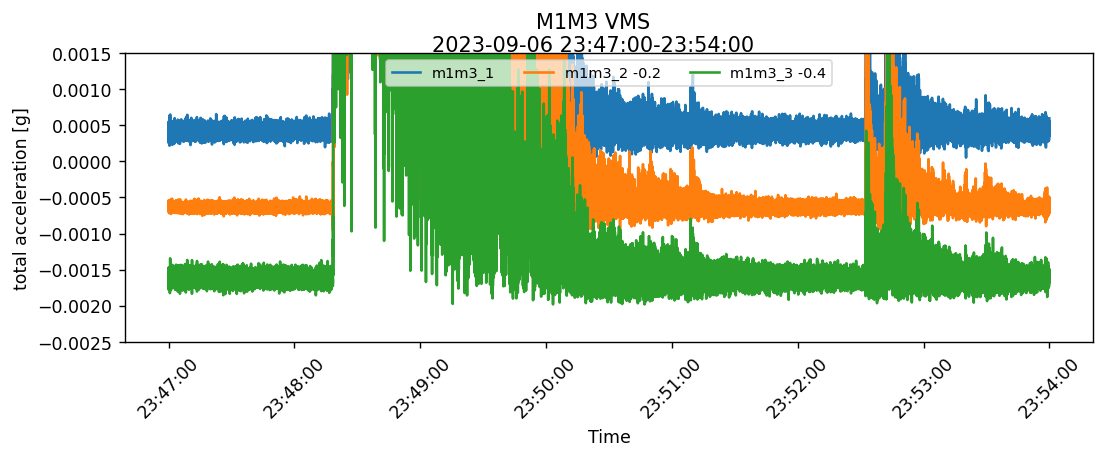

In [20]:
fig, ax = plt.subplots(1, dpi=125, sharex=True, figsize=(10, 3))
plt.suptitle(f"M1M3 VMS\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n", y=0.99)

labels = ["m1m3_1", "m1m3_2 -0.2", "m1m3_3 -0.4"]
for i in np.arange(3):
    ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime, 
            vms_m1m3_data[f"total_{i+1}"] - 0.001 * i,  # Aplicar offset
            label=labels[i])

ax.set(xlabel="Time", ylabel="total acceleration [g]", ylim=(-0.0025, 0.0015))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

legend= ax.legend(ncol=3, loc='upper center', fontsize='small')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.7)

1.2. Total acceleration telemetry for each of the 3 m1m3 vms channels (less zoom)

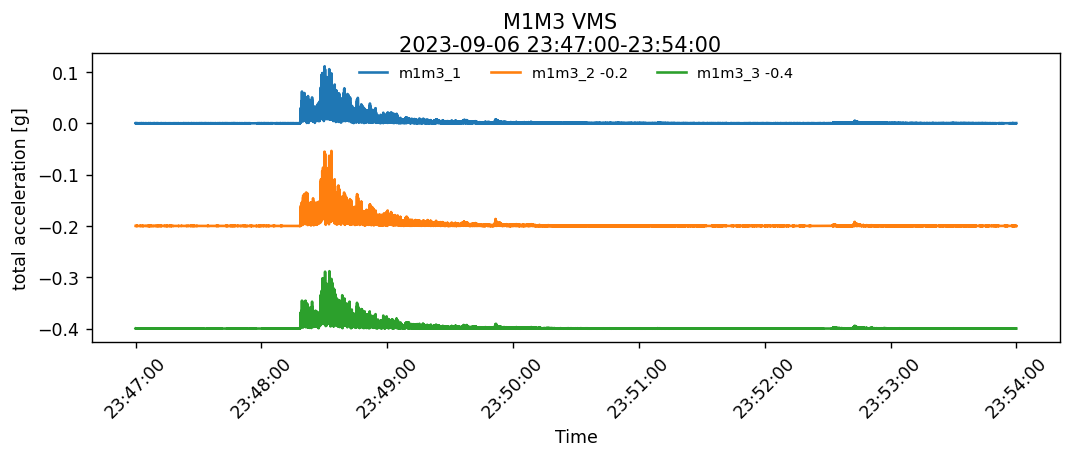

In [21]:
fig, ax = plt.subplots(1, dpi=125, sharex=True, figsize=(10, 3))
plt.suptitle(f"M1M3 VMS\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n", y=0.99)

# Ajustar el offset
offset = 0.2
labels = ["m1m3_1", "m1m3_2 -0.2", "m1m3_3 -0.4"]

for i in np.arange(3):
    ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime, 
            vms_m1m3_data[f"total_{i+1}"] - offset * i,  # Aplicar el offset
            label=labels[i])


ax.set(xlabel="Time", ylabel="total acceleration [g]")
ax.set_ylim(auto=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

ax.legend(ncol=3, loc='upper center', fontsize='small', frameon=False)

1.3. Plot of total acceleration telemetry (with an offset) of each axis (xyz) of each channel of the m1m3 vms channels

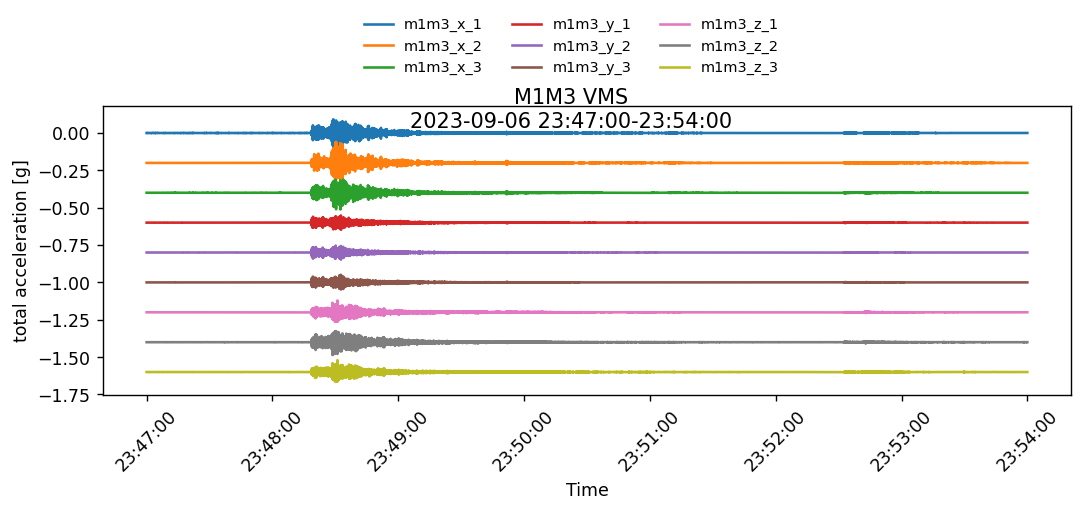

In [22]:
fig, ax = plt.subplots(1, dpi=125, sharex=True, figsize=(10, 3))
plt.suptitle(f"\nM1M3 VMS\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n", y=0.99)

# Ajustar el offset
offset = 0.2
labels = ["m1m3_x_1", "m1m3_x_2", "m1m3_x_3", "m1m3_y_1", "m1m3_y_2", "m1m3_y_3", "m1m3_z_1", "m1m3_z_2", "m1m3_z_3"]

for i, key in enumerate([i for i in sorted(key_m1m3_dict.values()) if ("m1m3" in i)]):
    ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime, 
            vms_m1m3_data[key] - offset * i,  # Aplicar el offset
            label=labels[i])

ax.set(xlabel="Time", ylabel="total acceleration [g]")
ax.set_ylim(auto=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

fig.legend(ncol=3, bbox_to_anchor=(0.5, 1.15), loc='upper center', fontsize='small', frameon=False)

plt.show()



1.4. Plot of total acceleration telemetry (with an offset) of each axis (xyz) of the m1m3 vms channels

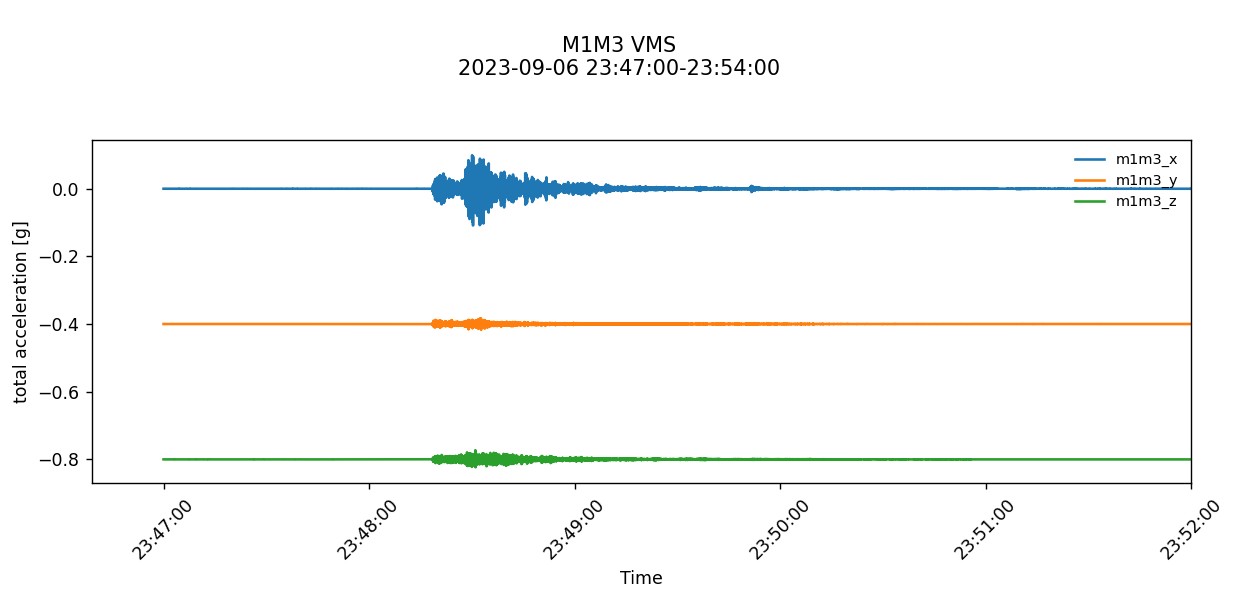

In [23]:
fig, ax = plt.subplots(1, dpi=125, sharex=True, figsize=(10, 5))
# Lowering the title by reducing the 'y' parameter
plt.suptitle(f"\nM1M3 VMS\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n", y=0.95)

# Grouping the keys by 'x', 'y', and 'z'
x_keys = [key for key in sorted(key_m1m3_dict.values()) if "m1m3_x" in key]
y_keys = [key for key in sorted(key_m1m3_dict.values()) if "m1m3_y" in key]
z_keys = [key for key in sorted(key_m1m3_dict.values()) if "m1m3_z" in key]

# Calculating the average for each group
x_avg = np.mean([vms_m1m3_data[key] for key in x_keys], axis=0)
y_avg = np.mean([vms_m1m3_data[key] for key in y_keys], axis=0)
z_avg = np.mean([vms_m1m3_data[key] for key in z_keys], axis=0)

# Define the offset to separate the plots
offset = 0.4

# Plotting the combined results with an offset
ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime, x_avg, label="m1m3_x")
ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime, y_avg - offset, label="m1m3_y")
ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime, z_avg - 2 * offset, label="m1m3_z")

# Set labels and formatting
ax.set(xlabel="Time", ylabel="total acceleration [g]")
ax.set_ylim(auto=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

# Set the x-axis limit to cut off at 23:50
end_time_limit = Time(begin_time.iso[:10] + ' 23:52:00', format='iso').datetime
ax.set_xlim(right=end_time_limit)

# Place the legend inside the plot, in the upper right corner
ax.legend(loc='upper right', fontsize='small', frameon=False)

# Adjust the layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### HP Forces

The limit required to keep the mirror safe during a mag 6 earthquake must be less than 3000 N. Let's study the and HP forces along the same axes and compare them with the accelerations.

In [10]:
# Select data from a given date
dayObs = 20230906
eventMaker = TMAEventMaker()
event = eventMaker.getEvents(dayObs)
print(event)

[]


It seems that there is no information on the TMA for 2023-09-06, therefore we will not be able to perform the HP forces analysis.

we cannot make the comparison because the telescope was shut down from 4 August to 15 November 2023, so no information is available. 

#### PSD (Power Spectral Density)

2.1. A Power Spectral Density (psd) of each axis (xyz) of each channel of the m1m3 vms data


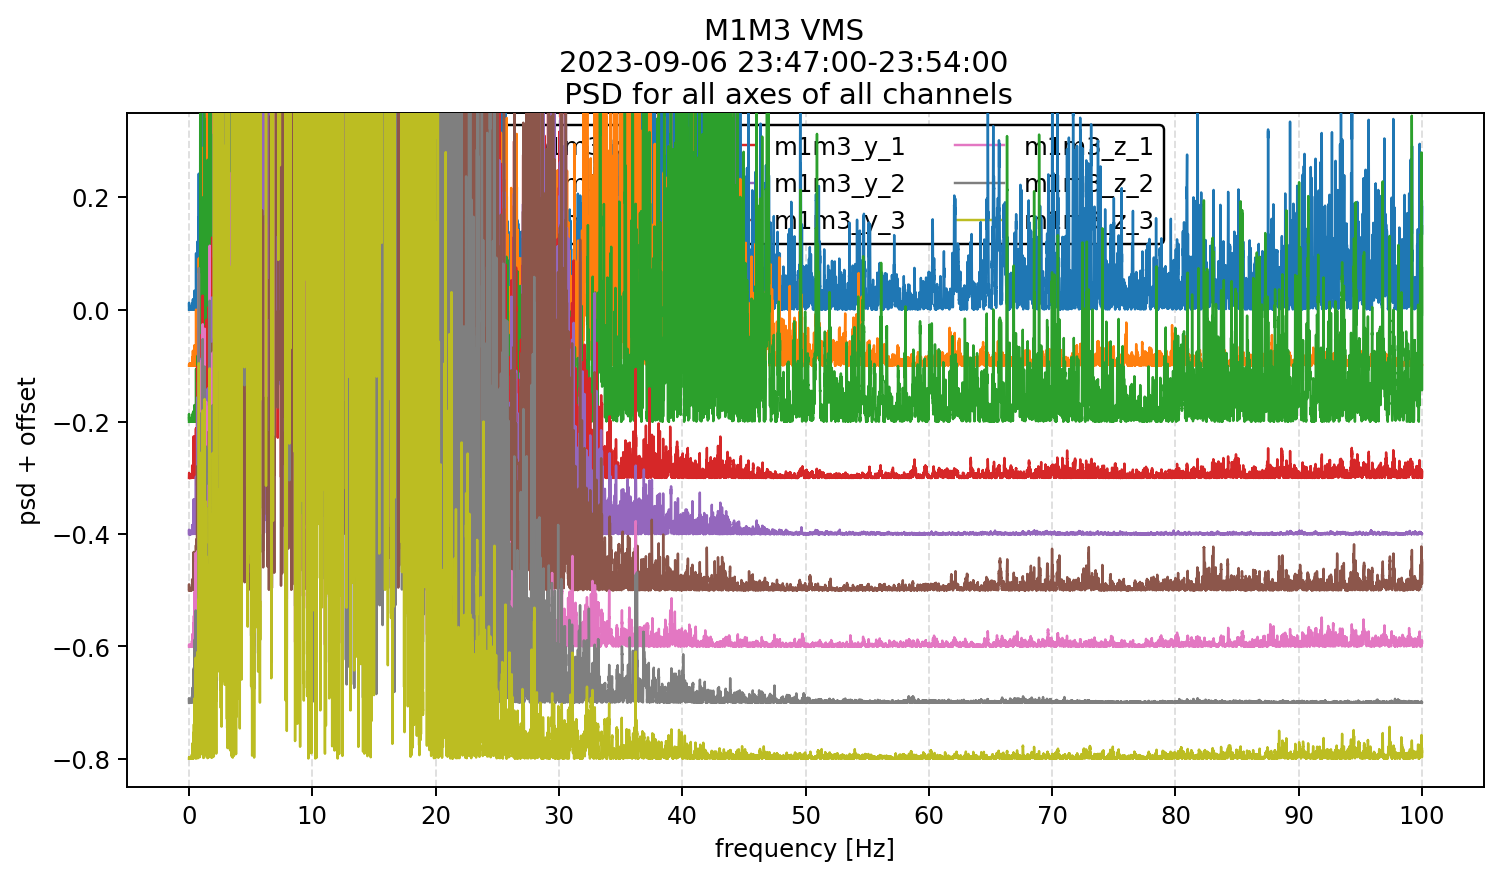

In [12]:
plt.figure(dpi=175,figsize=(10,5))
plt.suptitle(f"M1M3 VMS\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n PSD for all axes of all channels", y=0.99)
step=0.1
for i,key in enumerate([i for i in sorted(key_m1m3_dict.values()) if ("m1m3" in i)]):
    
    freq,psd=get_freq_psd(vms_m1m3_data[key], np.mean(np.diff(vms_m1m3_data["times"])))
    points_x=get_peak_points(freq, psd)
    if points_x is not None:
        points_y=np.ones_like(points_x) * i * step * -1
        # print(f"{key}: {str([int(i) for i in points_x])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
    plt.plot(freq,psd - i * step, label=key, zorder=9, lw=1)

plt.legend(ncol=3, edgecolor="k", facecolor="white", loc=9, framealpha=1)
plt.ylim(-0.05 - i * step, 0.35)
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.grid(visible=True, axis="x", ls="dashed", alpha=0.4)
_=plt.xticks(np.arange(0,110,10))


2.2. A Power Spectral Density (psd) of each axis (xyz) of each channel of the m1m3 vms data (zoom)

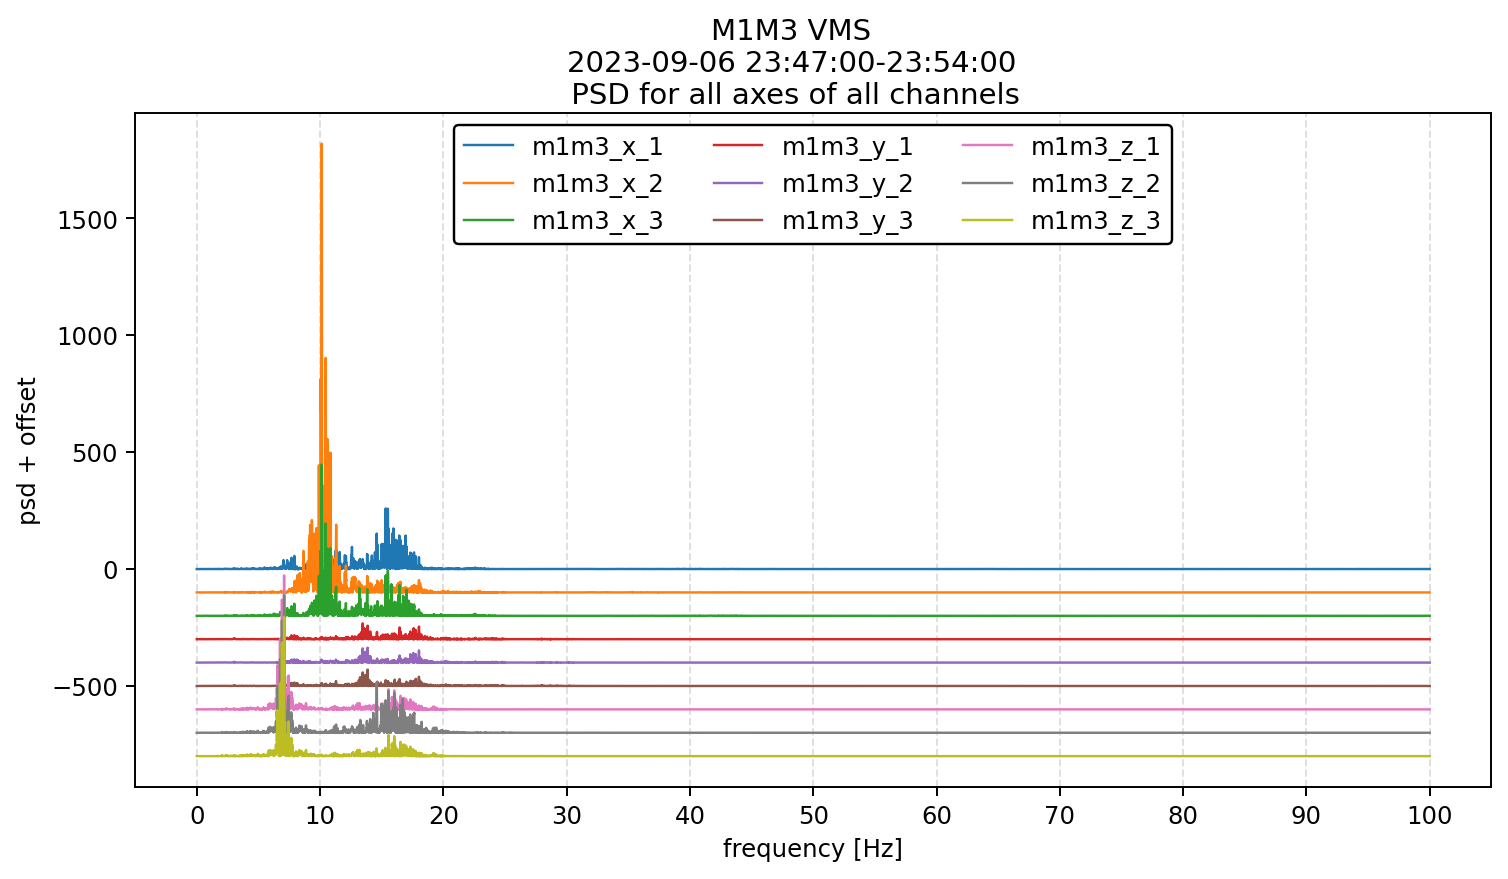

In [13]:
plt.figure(dpi=175,figsize=(10,5))
plt.suptitle(f"M1M3 VMS\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n PSD for all axes of all channels", y=0.99)
step=100
for i,key in enumerate([i for i in sorted(key_m1m3_dict.values()) if ("m1m3" in i)]):
    
    freq,psd=get_freq_psd(vms_m1m3_data[key], np.mean(np.diff(vms_m1m3_data["times"])))
    points_x=get_peak_points(freq, psd)
    if points_x is not None:
        points_y=np.ones_like(points_x) * i * step * -1
        # print(f"{key}: {str([int(i) for i in points_x])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
    plt.plot(freq,psd - i * step, label=key, zorder=9, lw=1)

plt.legend(ncol=3, edgecolor="k", facecolor="white", loc=9, framealpha=1)
#plt.ylim(-0.05 - i * step, 0.35)
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.grid(visible=True, axis="x", ls="dashed", alpha=0.4)
_=plt.xticks(np.arange(0,110,10))

We change the x-axis to better visualise the data.

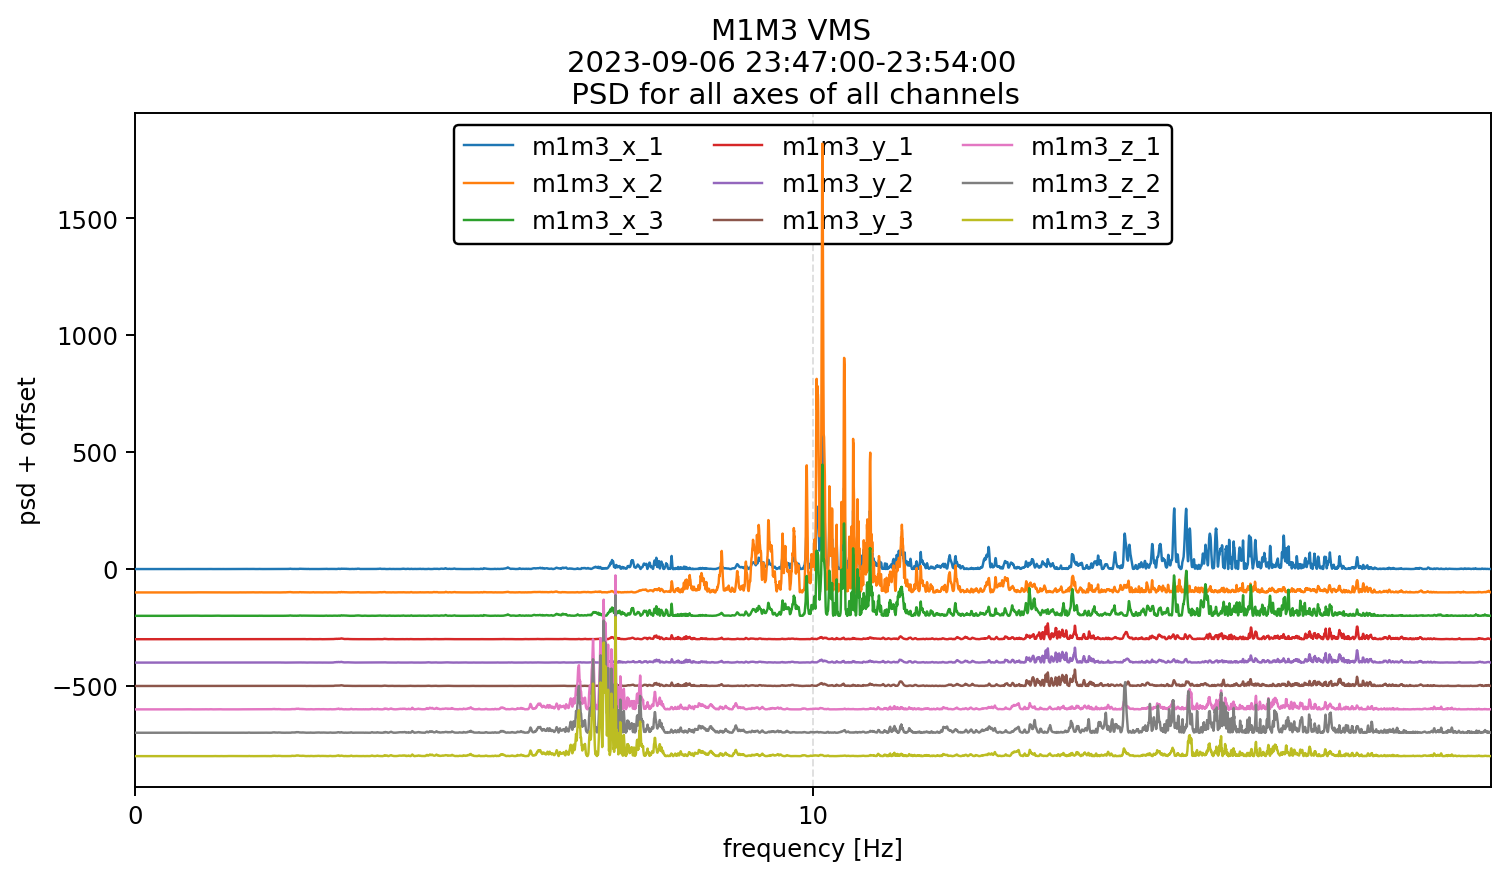

In [14]:
plt.figure(dpi=175, figsize=(10, 5))
plt.suptitle(f"M1M3 VMS\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n PSD for all axes of all channels", y=0.99)
step = 100

for i, key in enumerate([i for i in sorted(key_m1m3_dict.values()) if ("m1m3" in i)]):
    freq, psd = get_freq_psd(vms_m1m3_data[key], np.mean(np.diff(vms_m1m3_data["times"])))
    points_x = get_peak_points(freq, psd)
    
    if points_x is not None:
        points_y = np.ones_like(points_x) * i * step * -1
        # print(f"{key}: {str([int(i) for i in points_x])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
    
    plt.plot(freq, psd - i * step, label=key, zorder=9, lw=1)

plt.legend(ncol=3, edgecolor="k", facecolor="white", loc=9, framealpha=1)

plt.xlim(0, 20)

plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.grid(visible=True, axis="x", ls="dashed", alpha=0.4)
plt.xticks(np.arange(0, 20, 10))

plt.show()


## Analysis for the evening's event:  2023-10-31

### Loading VMS data

We analysed de data of the earthquake event of 31 October 2023.

In [24]:
vms_m1m3_filename_oct="/scratch/users/b/boutigny/vmsdata/2023/09/M1M3-2023-10-31T00:00.hdf"
begin_time=Time('2023-10-31 12:30:00', format="iso", scale="utc")
end_time=Time('2023-10-31 12:35:00', format="iso", scale="utc")

There is no VMS data for the night of 31 October 2023 so we will have to analyse the earthquake event differently from the one analysed for the night of 6 Septembre 2023.

### Loading IMF data

In [26]:
dayObs = 20231031
#begin = '23:47:00'
postPadding = 15  # in seconds, integration time will be 30 s

In [27]:
## Define column names
all_columns = [
    "xPosition",
    "yPosition",
    "zPosition",
    "xRotation",
    "yRotation",
    "zRotation",
]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [28]:
# Select data from a given date
eventMaker = TMAEventMaker()
event = eventMaker.getEvents(dayObs)
print(event)

[]


For observation night 2023-10-31 no IMF data is available.

It is possible that it would not have been necessary to read the data in this way and that the get_efd_data function would be sufficient. But as the dictionary was empty, this extra check was done. 

## EXTRA ANALYSIS

#### Earthquake events using the EFD client

In [ ]:
from lsst_efd_client import EfdClient
client = EfdClient('usdf_efd', db_name="lsst.backpack")

topics = await client.get_topics()
topics

In [ ]:
query = f'''SELECT * FROM "lsst.backpack.usgs_earthquake_data"'''
await client.influx_client.query(query)

In [ ]:
data = getEfdData(client, "lsst.backpack.usgs_earthquake_data", dayObs=20231031)
data

In [ ]:
import asyncio
import nest_asyncio
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, getTopics
client = makeEfdClient()

await asyncio.sleep(1)
nest_asyncio.apply()
print(getTopics(client, '*ess*'))  # to help you find a topic that related to the ESS
topic = 'lsst.sal.MTMount.elevation'
data = getEfdData(client, topic, dayObs=20231031)
print(f'Found {len(data)} rows of pressure data')  # lots of data

### RMS

In [ ]:
# rms
rolling = 10  

total_1 = vms_m1m3_data["total_1"]
total_2 = vms_m1m3_data["total_2"]
total_3 = vms_m1m3_data["total_3"]

rms_1 = total_1.rolling(rolling).std()
rms_2 = total_2.rolling(rolling).std()
rms_3 = total_3.rolling(rolling).std()

In [ ]:
fig, ax = plt.subplots(1, dpi=125, sharex=True, figsize=(10, 3))
plt.suptitle(f"M1M3 VMS\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n", y=0.99)

# Setting the offset
offset = 0.2
labels = ["m1m3_1", "m1m3_2 -0.2", "m1m3_3 -0.4"]

for i in np.arange(3):
    ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime, 
            vms_m1m3_data[f"total_{i+1}"] - offset * i,  # Aplicar el offset
            label=labels[i])

ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime,
        rms_1, linestyle='--', linewidth=1.0, color='red', label='RMS')

ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime,
        rms_2 - offset * 1, linestyle='--', linewidth=1.0, color='red')

ax.plot(Time(vms_m1m3_data["times"], format="unix").datetime,
        rms_3 - offset * 2, linestyle='--', linewidth=1.0, color='red')


ax.set(xlabel="Time", ylabel="total acceleration [m/s$^2$]")
ax.set_ylim(auto=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

ax.legend(ncol=3, loc='upper center', fontsize='small', frameon=False)

In [ ]:
# Definimos los datos a utilizar
times = Time(vms_m1m3_data["times"], format="unix").datetime

# Gráfica para total_1
fig, ax1 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax1.set_title(f"M1M3 VMS - m1m3_x\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax1.plot(times, vms_m1m3_data["total_1"], label="m1m3_1", color='tab:blue')
ax1.plot(times, rms_1, linestyle='--', linewidth=1.0, color='red', label='RMS')
ax1.set(xlabel="Time", ylabel="total acceleration [m/s$^2$]")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Gráfica para total_2
fig, ax2 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax2.set_title(f"M1M3 VMS - m1m3_y\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax2.plot(times, vms_m1m3_data["total_2"], label="m1m3_2", color='tab:orange')
ax2.plot(times, rms_2, linestyle='--', linewidth=1.0, color='red', label='RMS')
ax2.set(xlabel="Time", ylabel="total acceleration [m/s$^2$]")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Gráfica para total_3
fig, ax3 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax3.set_title(f"M1M3 VMS - m1m3_z\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax3.plot(times, vms_m1m3_data["total_3"], label="m1m3_3", color='tab:green')
ax3.plot(times, rms_3, linestyle='--', linewidth=1.0, color='red', label='RMS')
ax3.set(xlabel="Time", ylabel="total acceleration [m/s$^2$]")
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax3.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Show the plots
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time

# Definimos los datos a utilizar
times = Time(vms_m1m3_data["times"], format="unix").datetime

# Límites del eje Y
y_min, y_max = -0.0005, 0.01

# Gráfica para total_1
fig, ax1 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax1.set_title(f"M1M3 VMS - m1m3_x\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax1.plot(times, vms_m1m3_data["total_1"], label="m1m3_1", color='tab:blue')
ax1.plot(times, rms_1, linestyle='--', linewidth=1.0, color='red', label='RMS')
# Añadir la línea horizontal a 1e-6, más fina
ax1.axhline(y=1e-6, color='black', linestyle='--', linewidth=0.7, label='RMS requirement')
ax1.set(xlabel="Time", ylabel="Total Acceleration [m/s$^2$]", ylim=(y_min, y_max))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Gráfica para total_2
fig, ax2 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax2.set_title(f"M1M3 VMS - m1m3_y\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax2.plot(times, vms_m1m3_data["total_2"], label="m1m3_2", color='tab:orange')
ax2.plot(times, rms_2, linestyle='--', linewidth=1.0, color='red', label='RMS')
# Añadir la línea horizontal a 1e-6, más fina
ax2.axhline(y=1e-6, color='black', linestyle='--', linewidth=0.7, label='RMS requirement')
ax2.set(xlabel="Time", ylabel="Total Acceleration [m/s$^2$]", ylim=(y_min, y_max))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Gráfica para total_3
fig, ax3 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax3.set_title(f"M1M3 VMS - m1m3_z\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax3.plot(times, vms_m1m3_data["total_3"], label="m1m3_3", color='tab:green')
ax3.plot(times, rms_3, linestyle='--', linewidth=1.0, color='red', label='RMS')
# Añadir la línea horizontal a 1e-6, más fina
ax3.axhline(y=1e-6, color='black', linestyle='--', linewidth=0.7, label='RMS requirement')
ax3.set(xlabel="Time", ylabel="Total Acceleration [m/s$^2$]", ylim=(y_min, y_max))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax3.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Mostrar las gráficas
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time

# Definimos los datos a utilizar
times = Time(vms_m1m3_data["times"], format="unix").datetime

# Límites iniciales del eje Y (ajustaremos después de verificar los valores RMS)
y_min, y_max = -0.01, 0.02

# Valores RMS requeridos
rms_requirement = 1e-6

# Gráfica para total_1
fig, ax1 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax1.set_title(f"M1M3 VMS - m1m3_x\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax1.plot(times, vms_m1m3_data["total_1"], label="m1m3_1", color='tab:blue')
ax1.plot(times, rms_1, linestyle='--', linewidth=1.0, color='red', label='RMS')
# Añadir la línea horizontal de RMS requirement
ax1.axhline(y=rms_requirement, color='black', linestyle='--', linewidth=0.5, label='RMS requirement')
ax1.set(xlabel="Time", ylabel="Total Acceleration [m/s$^2$]", ylim=(y_min, y_max))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Mostrar el valor RMS calculado en el gráfico
rms_calculated_1 = rms_1.mean()  # Por ejemplo, podrías usar el promedio del RMS
ax1.text(0.01, 0.95, f'RMS calculated: {rms_calculated_1:.2e} m/s²', transform=ax1.transAxes, fontsize=9, verticalalignment='top')

# Ajustar límites del eje Y para que el RMS requirement sea visible
y_min_1, y_max_1 = vms_m1m3_data["total_1"].min(), vms_m1m3_data["total_1"].max()
ax1.set_ylim([min(y_min_1, rms_requirement) - 0.01, max(y_max_1, rms_requirement) + 0.01])

# Gráfica para total_2
fig, ax2 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax2.set_title(f"M1M3 VMS - m1m3_y\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax2.plot(times, vms_m1m3_data["total_2"], label="m1m3_2", color='tab:orange')
ax2.plot(times, rms_2, linestyle='--', linewidth=1.0, color='red', label='RMS')
# Añadir la línea horizontal de RMS requirement
ax2.axhline(y=rms_requirement, color='black', linestyle='--', linewidth=0.5, label='RMS requirement')
ax2.set(xlabel="Time", ylabel="Total Acceleration [m/s$^2$]", ylim=(y_min, y_max))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Mostrar el valor RMS calculado en el gráfico
rms_calculated_2 = rms_2.mean()  # Por ejemplo, podrías usar el promedio del RMS
ax2.text(0.01, 0.95, f'RMS calculated: {rms_calculated_2:.2e} m/s²', transform=ax2.transAxes, fontsize=9, verticalalignment='top')

# Ajustar límites del eje Y para que el RMS requirement sea visible
y_min_2, y_max_2 = vms_m1m3_data["total_2"].min(), vms_m1m3_data["total_2"].max()
ax2.set_ylim([min(y_min_2, rms_requirement) - 0.01, max(y_max_2, rms_requirement) + 0.01])

# Gráfica para total_3
fig, ax3 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax3.set_title(f"M1M3 VMS - m1m3_z\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax3.plot(times, vms_m1m3_data["total_3"], label="m1m3_3", color='tab:green')
ax3.plot(times, rms_3, linestyle='--', linewidth=1.0, color='red', label='RMS')
# Añadir la línea horizontal de RMS requirement
ax3.axhline(y=rms_requirement, color='black', linestyle='--', linewidth=0.5, label='RMS requirement')
ax3.set(xlabel="Time", ylabel="Total Acceleration [m/s$^2$]", ylim=(y_min, y_max))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax3.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Mostrar el valor RMS calculado en el gráfico
rms_calculated_3 = rms_3.mean()  # Por ejemplo, podrías usar el promedio del RMS
ax3.text(0.01, 0.95, f'RMS calculated: {rms_calculated_3:.2e} m/s²', transform=ax3.transAxes, fontsize=9, verticalalignment='top')

# Ajustar límites del eje Y para que el RMS requirement sea visible
y_min_3, y_max_3 = vms_m1m3_data["total_3"].min(), vms_m1m3_data["total_3"].max()
ax3.set_ylim([min(y_min_3, rms_requirement) - 0.01, max(y_max_3, rms_requirement) + 0.01])

# Mostrar las gráficas
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time

# Definimos los datos a utilizar
times = Time(vms_m1m3_data["times"], format="unix").datetime

# Límites del eje Y (fijos para todas las gráficas)
y_min, y_max = -0.001, 0.001

# Valores RMS requeridos
rms_requirement = 1e-6

# Gráfica para total_1
fig, ax1 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax1.set_title(f"M1M3 VMS - m1m3_x\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax1.plot(times, vms_m1m3_data["total_1"], label="m1m3_1", color='tab:blue')
ax1.plot(times, rms_1, linestyle='--', linewidth=1.0, color='red', label='RMS')
# Añadir la línea horizontal de RMS requirement
ax1.axhline(y=rms_requirement, color='black', linestyle='--', linewidth=0.5, label='RMS requirement')
ax1.set(xlabel="Time", ylabel="Total Acceleration [m/s$^2$]", ylim=(y_min, y_max))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Mostrar el valor RMS calculado en el gráfico
rms_calculated_1 = rms_1.mean()  # Por ejemplo, podrías usar el promedio del RMS
ax1.text(0.01, 0.95, f'RMS calculated: {rms_calculated_1:.2e} m/s²', transform=ax1.transAxes, fontsize=9, verticalalignment='top')

# Gráfica para total_2
fig, ax2 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax2.set_title(f"M1M3 VMS - m1m3_y\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax2.plot(times, vms_m1m3_data["total_2"], label="m1m3_2", color='tab:orange')
ax2.plot(times, rms_2, linestyle='--', linewidth=1.0, color='red', label='RMS')
# Añadir la línea horizontal de RMS requirement
ax2.axhline(y=rms_requirement, color='black', linestyle='--', linewidth=0.5, label='RMS requirement')
ax2.set(xlabel="Time", ylabel="Total Acceleration [m/s$^2$]", ylim=(y_min, y_max))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Mostrar el valor RMS calculado en el gráfico
rms_calculated_2 = rms_2.mean()  # Por ejemplo, podrías usar el promedio del RMS
ax2.text(0.01, 0.95, f'RMS calculated: {rms_calculated_2:.2e} m/s²', transform=ax2.transAxes, fontsize=9, verticalalignment='top')

# Gráfica para total_3
fig, ax3 = plt.subplots(1, dpi=125, figsize=(10, 3))
ax3.set_title(f"M1M3 VMS - m1m3_z\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
ax3.plot(times, vms_m1m3_data["total_3"], label="m1m3_3", color='tab:green')
ax3.plot(times, rms_3, linestyle='--', linewidth=1.0, color='red', label='RMS')
# Añadir la línea horizontal de RMS requirement
ax3.axhline(y=rms_requirement, color='black', linestyle='--', linewidth=0.5, label='RMS requirement')
ax3.set(xlabel="Time", ylabel="Total Acceleration [m/s$^2$]", ylim=(y_min, y_max))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax3.legend(loc='upper right', fontsize='small', frameon=False)
plt.xticks(rotation=45)

# Mostrar el valor RMS calculado en el gráfico
rms_calculated_3 = rms_3.mean()  # Por ejemplo, podrías usar el promedio del RMS
ax3.text(0.01, 0.95, f'RMS calculated: {rms_calculated_3:.2e} m/s²', transform=ax3.transAxes, fontsize=9, verticalalignment='top')

# Mostrar las gráficas
plt.show()
